In [19]:
# Cell to hide - just an option and import other functions

import pandas as pd
pd.set_option('display.max_columns', 27)

%run 1-functions.ipynb

__TODO: the whole thing__

## Prediction from all data vs. splitted dataset

Your customer would like to have a model that can predict the mean speed of a vessel based on its type and size. As we will see together, this task is not the easiest with the dataset we have, as it contains a lot of different ships with different goals at sea.

In [69]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

### Prediction using the whole dataset

We will start by predicting simply the ``MeanSOG`` using the ``VesselType``, ``Length``, ``Width`` and ``Draft``. Let's add the attribute names into the variables ``x`` and ``y``.

In [70]:
x = ['VesselType', 'Length', 'Width', 'Draft']
y = ['MeanSOG']

Now we can simply use the function ``knn_regression()`` to make predictions.

In [73]:
predictions, y_test = knn_regression(static_data, x, y)
print('MAE: ' + str(mean_absolute_error(predictions, y_test)))

MAE: 1.2733923934326852


To better undestand if the MAE is good, we need to know the distribution, the max and min values of the attribute we are trying to predict:

In [72]:
static_data['MeanSOG'].describe()

count    1520.000000
mean        1.034825
std         2.936439
min        -0.100000
25%         0.000000
50%         0.012633
75%         0.072000
max        20.360811
Name: MeanSOG, dtype: float64

The mean value of ``MeanSOG`` is ``1.03`` knots, so we can imagine that our MAE of ``1.27`` is not a very good performance. To try to understand why we get this performance, let's visually analyze the distribution of the attribute and the predictions made by the model.

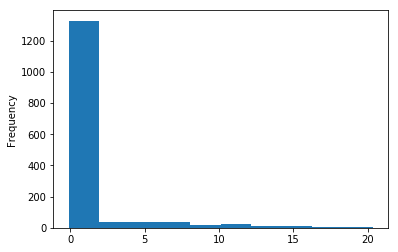

In [74]:
static_data['MeanSOG'].plot.hist()

First, we see that the dataset contains a lot of low values for the attribute ``MeanSOG``. Let's look at the predictions made:

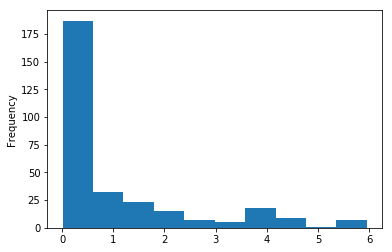

In [75]:
# We need to rearrange the list predictions to be able to use the function hist()
pred = []
for element in predictions:
    pred.append(element[0])
    
pd.Series(pred).plot.hist()

Let's compare this histogram with the one of the real values:

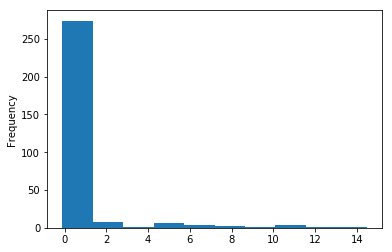

In [84]:
pd.Series(y_test['MeanSOG']).plot.hist()

We see that the model gives much more predictions of low value, but there is still a big difference between predictions and true labels.

How could we try to build a model that gives good predictions for the mean speed of ships with such an unbalanced dataset?

One solution could be to split the dataset between low speed ships and "normal" speed ships. When the customer wants to make a prediction, they should be able to tell if the ship they want to predict the speed is mobile or not, and then be able to select the right model: for mobile or immobile ships. Let's have a look at this idea.

### Split the dataset

According to the distribution of the data we saw before, we can tell that most low values are under 1. So, let's split the dataset into mobile and immobile ships, taking the value 1 of mean speed for the threshold. For the selection of the data, we use the function [loc()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html).

We will do the analysis on the mobile ships only, as it doesn't seem interesting to predict the mean speed of an immobile ship.

In [87]:
mobile = static_data.loc[static_data['MeanSOG'] >= 1]

Now let's try to make predictions for the new dataset and analyze the performance.

In [91]:
# Prediction for mobile ships

predictions2, y_test2 = knn_regression(mobile, x, y)
print('MAE: ' + str(mean_absolute_error(predictions2, y_test2)))

MAE: 2.8503720152323386


In [97]:
mobile['MeanSOG'].mean()

7.006852415734686

Without looking at the histograms, we can already get an idea of the performance of the model.

### Compare the results

The model for mobile ships seems to be giving better results compared to the mean value of the dataset. Of course, the MAE in general is much higher than the one of the model with the whole dataset, but we saw that the model seemed to be only good for predicting the low values of MeanSOG.
Let's check this out.

In [100]:
pred = []
for element in predictions:
    pred.append(element[0])

# Create two lists to collect true labels with MeanSOG >= 1 and the corresponding predictions
pred_sup1 = []
y_test_sup1 = []

i = 0
for value in y_test['MeanSOG']:
    if value >= 1:
        y_test_sup1.append(value)
        pred_sup1.append(pred[i])
    i = i + 1
    
print(mean_absolute_error(pred_sup1, y_test_sup1))

3.950739471015331


The mean absolute error on the mobile ships with the first model (the one using the whole dataset) is higher than the one we got with the new model when splitting the data. This is a good sign that splitting the data helped to create a better model for the moving ships.

To go further, we can have a look at the boxplots of the predictions of both models. This is another type of visualization of the data which can instantly inform us on the state of the prediction and the possible need to build several models for several cases.

{'whiskers': [<matplotlib.lines.Line2D at 0x1e18bc9cc88>,
 'caps': [<matplotlib.lines.Line2D at 0x1e18bcf63c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e18bc9c470>],
 'medians': [<matplotlib.lines.Line2D at 0x1e18d9f2d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e18d9f2dd8>],
 'means': []}

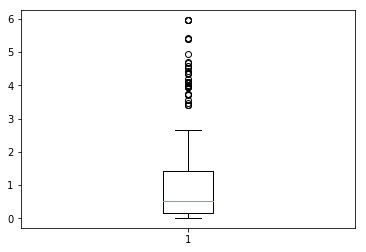

In [103]:
# Boxplot of the predictions with the first model
plt.boxplot(predictions)

We can see with this boxplot that most predicted values are low, and the highest values are considered as outliers. Let's compare it with the boxplot of the predictions made by the second model.

{'whiskers': [<matplotlib.lines.Line2D at 0x1e18da6a2e8>,
 'caps': [<matplotlib.lines.Line2D at 0x1e18da6a978>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e18da5feb8>],
 'medians': [<matplotlib.lines.Line2D at 0x1e18da6ada0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e18da73390>],
 'means': []}

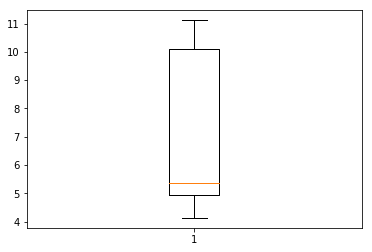

In [104]:
# Boxplot of the predictions with the second model
plt.boxplot(predictions2)

Here, the predictions are much more homogeneous. This seems more acceptable for a predictive model, as we want a model that can generalize on new data.

### Generalization

What this experiment taught us is that sometimes, the data used to build a model are too heterogeneous and should be splitted, if they could. In our case, it makes sense to split the data between mobile and immobile ships, as it is an easy feature to verify before using a model to predict the speed. Also, predicting the speed of a ship that is actually moving seems much more interesting than predicting the speed of a ship that doesn't move.

In general, it is important to check that the data used for training a model are a good representation of the environment in which the model will be in use later.

## Prediction with identical data

For this task, we want to explore the effects on prediction of a bug in the collection of the data: let's simulate a situation where a bug in transmission added a lot of identical rows to the dataset. We will make prediction of the mean speed of the ships from several datasets with several percentages of identical rows, and compare the results.

First, we import the dataset. We use again the static data for this task.

In [105]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

We choose a row without a lot of missing values, to have an interesting row to copy.

In [7]:
static_data.head()

,TripID,MMSI,MeanSOG,VesselName,IMO,CallSign,VesselType,Length,Width,Draft,Cargo,DepTime,ArrTime,DepLat,DepLon,ArrLat,ArrLon,DepCountry,DepCity,ArrCountry,ArrCity,Duration
0,1,367114690,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:06,2017-01-01 02:40:45,48.51094,-122.60705,48.51095,-122.60705,US,Anacortes,US,Anacortes,0 days 02:40:39
1,2,367479990,6.536585,WSF KENNEWICK,IMO9618331,WDF6991,1012.0,83.39,19.5,3.2,NaN,2017-01-01 00:00:03,2017-01-01 02:40:44,48.15891,-122.67268,48.11099,-122.75885,US,Coupeville,US,Port Townsend,0 days 02:40:41
2,3,368319000,0.000758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:08,2017-01-01 02:44:48,43.34576,-124.32142,43.34578,-124.32141,US,Barview,US,Barview,0 days 02:44:40
3,4,367154100,6.871111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:15,2017-01-01 02:33:28,46.74264,-124.93125,47.02928,-124.95153,US,Ocean Shores,US,Ocean Shores,0 days 02:33:13
4,5,367446870,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00:59,2017-01-01 02:42:54,48.51320,-122.60718,48.51318,-122.60699,US,Anacortes,US,Anacortes,0 days 02:41:55


The second row will do. Now, we create a few datasets by adding this row 10 (``df10``), 100 (``df100``), 1000 (``df1000``) and 10000 (``df10000``) times. The creation of the last 2 datasets might take a bit of time (can take up to 1-2 minutes __TODO: change this when we have the server with the real execution time__).

In [115]:
line = static_data.loc[1]
df10 = static_data.append(line)
for i in range(9):
    df10 = df10.append(line)

In [116]:
line = static_data.loc[1]
df100 = df10.append(line)
for i in range(89):
    df100 = df100.append(line)

In [117]:
%%time
line = static_data.loc[1]
df1000 = df100.append(line)
for i in range(889):
    df1000 = df1000.append(line)

Wall time: 4.62 s


In [118]:
%%time
line = static_data.loc[1]
df10000 = df1000.append(line)
for i in range(8889):
    df10000 = df10000.append(line)

Wall time: 58.9 s


We can now have a look at the basic distribution of some of the new datasets. Look at how the distribution of the attributes change when we add identical data.

In [110]:
static_data.describe()

,TripID,MMSI,MeanSOG,VesselType,Length,Width,Draft,Cargo,DepLat,DepLon,ArrLat,ArrLon
count,1520.000000,1.520000e+03,1520.000000,1287.000000,1220.000000,911.000000,496.000000,378.000000,1520.000000,1520.000000,1520.000000,1520.000000
mean,760.500000,3.597421e+08,1.034825,971.680653,56.769590,13.104501,6.457056,50.515873,46.354331,-122.868905,46.353671,-122.871346
std,438.930518,6.263661e+07,2.936439,198.957887,74.739358,10.903338,4.607529,22.693810,3.766705,0.681947,3.762056,0.680604
min,1.000000,3.160089e+06,-0.100000,0.000000,6.710000,0.000000,0.000000,0.000000,32.220640,-125.995610,32.209370,-125.998590
25%,380.750000,3.380724e+08,0.000000,1004.000000,14.840000,5.500000,3.000000,31.000000,46.168652,-123.178480,46.168460,-123.168262
50%,760.500000,3.669802e+08,0.012633,1019.000000,22.340000,8.000000,4.650000,52.000000,47.647795,-122.651365,47.646925,-122.645290
75%,1140.250000,3.675663e+08,0.072000,1019.000000,41.277500,16.350000,10.025000,70.000000,48.656940,-122.386562,48.665710,-122.386607
max,1520.000000,9.876543e+08,20.360811,1025.000000,349.000000,50.000000,18.800000,99.000000,49.890740,-120.002920,49.832120,-120.002420


In [113]:
df100.describe()

,TripID,MMSI,MeanSOG,VesselType,Length,Width,Draft,Cargo,DepLat,DepLon,ArrLat,ArrLon
count,1620.000000,1.620000e+03,1620.000000,1387.000000,1320.000000,1011.000000,596.000000,378.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,713.679012,3.602198e+08,1.374440,974.587599,58.786288,13.737092,5.910570,50.515873,46.465725,-122.856792,46.462148,-122.864401
std,462.711743,6.069995e+07,3.137564,191.929855,72.195062,10.524324,4.375517,22.693810,3.674295,0.662237,3.668495,0.659805
min,1.000000,3.160089e+06,-0.100000,0.000000,6.710000,0.000000,0.000000,0.000000,32.220640,-125.995610,32.209370,-125.998590
25%,305.750000,3.381017e+08,0.000000,1004.000000,15.202500,5.900000,3.200000,31.000000,46.196967,-123.148207,46.196975,-123.142782
50%,710.500000,3.670365e+08,0.017647,1019.000000,23.800000,9.140000,3.900000,52.000000,47.659110,-122.672680,47.658825,-122.719000
75%,1115.250000,3.675345e+08,0.138056,1019.000000,83.390000,19.500000,9.525000,70.000000,48.609527,-122.390568,48.609538,-122.390013
max,1520.000000,9.876543e+08,20.360811,1025.000000,349.000000,50.000000,18.800000,99.000000,49.890740,-120.002920,49.832120,-120.002420


In [114]:
df10000.describe()

,TripID,MMSI,MeanSOG,VesselType,Length,Width,Draft,Cargo,DepLat,DepLon,ArrLat,ArrLon
count,11400.000000,1.140000e+04,11400.000000,11167.000000,11100.000000,10791.000000,10376.000000,378.000000,11400.000000,11400.000000,11400.000000,11400.000000
mean,103.133333,3.664483e+08,5.803017,1007.353183,80.464153,18.960078,3.355696,50.515873,47.918300,-122.698843,47.876681,-122.773849
std,303.580083,2.301595e+07,2.155721,68.736725,26.131180,3.631543,1.223023,22.693810,1.505657,0.257723,1.497627,0.251376
min,1.000000,3.160089e+06,-0.100000,0.000000,6.710000,0.000000,0.000000,0.000000,32.220640,-125.995610,32.209370,-125.998590
25%,2.000000,3.674800e+08,6.536585,1012.000000,83.390000,19.500000,3.200000,31.000000,48.158910,-122.672680,48.110990,-122.758850
50%,2.000000,3.674800e+08,6.536585,1012.000000,83.390000,19.500000,3.200000,52.000000,48.158910,-122.672680,48.110990,-122.758850
75%,2.000000,3.674800e+08,6.536585,1012.000000,83.390000,19.500000,3.200000,70.000000,48.158910,-122.672680,48.110990,-122.758850
max,1520.000000,9.876543e+08,20.360811,1025.000000,349.000000,50.000000,18.800000,99.000000,49.890740,-120.002920,49.832120,-120.002420


Let's now do a prediction of the ``MeanSOG`` from the other attributes, for each of our datasets.

For that, we make a loop on each dataset, build a model and collect the error in the variable ``error``. Then, we print and plot the errors to look at the variation according to the dataset.

df: MAE = 1.2733923934326852
df10: MAE = 1.157407804442135
df100: MAE = 1.23786706177166
df1000: MAE = 0.9026804630340876
df10000: MAE = 0.20197894745555736


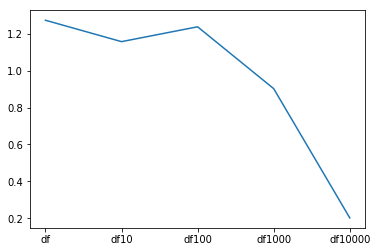

In [14]:
# Comparison of prediction of MeanSOG with normal static data and copied datasets

from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

x = ['VesselType', 'Length', 'Width', 'Draft']
y = ['MeanSOG']

errors = [[], []]

static_data.name = 'df'
df10.name = 'df10'
df100.name = 'df100'
df1000.name = 'df1000'
df10000.name = 'df10000'

for df in [static_data, df10, df100, df1000, df10000]:
    predictions, y_test = knn_regression(df, x, y)
    error = mean_absolute_error(predictions, y_test)
    print(df.name + ': MAE = ' + str(error))
    
    errors[0].append(df.name)
    errors[1].append(error)
    
plt.plot(errors[0], errors[1])

We can see that the error decreases drastically when we add more identical rows to the dataset. This is due to the fact that the model then learns almost only from that row, and predicts only the value of that row. We can have a look at that by observing the predictions made by the model with 10000 copies of the row:

In [ ]:
predictions, y_test = knn_regression(df10000, x, y)
print(mean_absolute_error(predictions, y_test))



## 3
More ideas
+ Try to predict with something that does not make sense (example: using ID attribute as a number)
+ or using Length as a category
+ mixing regression and classification

In [15]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

In [16]:
# Prediction of Width from Length or TripID

from sklearn.metrics import mean_absolute_error

x = ['Length']
y = ['Width']
pred, ytest = knn_regression(static_data, x, y)
print('MAE with Length: ' + str(mean_absolute_error(pred, ytest)))

x = ['Length', 'TripID']
y = ['Width']
pred, ytest = knn_regression(static_data, x, y)
print('MAE with Length and TripID: ' + str(mean_absolute_error(pred, ytest)))

x = ['TripID']
y = ['Width']
pred, ytest = knn_regression(static_data, x, y)
print('MAE with TripID: ' + str(mean_absolute_error(pred, ytest)))

print('Baseline: mean = ' + str(static_data['Width'].mean()))

MAE with Length: 2.73451052631579
MAE with Length and TripID: 3.8834960526315796
MAE with TripID: 7.796980263157895
Baseline: mean = 13.10450054884743


In [17]:
# Prediction of Width from Length: comparison regression and classification

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

x = ['Length']
y = ['Width']

df = static_data.copy()
df = df.dropna()

pred, ytest = knn_regression(df, x, y)

print('MAE with regression: ' + str(mean_absolute_error(pred, ytest)))

df2 = static_data.copy()
df2 = df2.dropna()
df2['Width'] = df2['Width'].astype('int')
df2['Width'] = df2['Width'].astype('category')

pred, ytest = knn_classification(df2, x, y)

print('Accuracy with classification: ' + str(accuracy_score(pred, ytest)))

MAE with regression: 2.0717238095238097
Accuracy with classification: 0.38095238095238093


C:\Users\Anna\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
